### Necessary Packages

In [1]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader,Subset
from torch import nn,Tensor
from torch.optim import Adam
from typing import Callable,Optional,Any
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision.models import efficientnet_b0,shufflenet_v2_x1_0
from torchvision.models import ShuffleNet_V2_X1_0_Weights,EfficientNet_B0_Weights
from torchsummary import summary
from torchmetrics import Accuracy,F1Score,Recall,Precision,AUROC,Metric
from trainer.trainer import Trainer
from tqdm.notebook import tqdm

### Global

In [2]:
DATASET_PATH = os.path.join(".", "COVID-19_Radiography_Dataset")
WORKING_DIR = os.path.join(".", "working")
WEIGHTS_FOLDER = os.path.join(WORKING_DIR, "weights")
HISTORY_FOLDER = os.path.join(WORKING_DIR, "histories")
FIGURES_FOLDER = os.path.join(WORKING_DIR, "figures")
TEST_SIZE = 0.3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WROKERS = 4
PREFETCH_FACTOR = 2

In [3]:
print(DATASET_PATH)
print(WORKING_DIR)
print(WEIGHTS_FOLDER)
print(HISTORY_FOLDER)
print(FIGURES_FOLDER)
print(DEVICE)

./COVID-19_Radiography_Dataset
./working
./working/weights
./working/histories
./working/figures
cuda


In [4]:
def init():

    if not os.path.exists(WEIGHTS_FOLDER):
        os.mkdir(WEIGHTS_FOLDER)
        
    if not os.path.exists(HISTORY_FOLDER):
        os.mkdir(HISTORY_FOLDER)

    if not os.path.exists(FIGURES_FOLDER):
        os.mkdir(FIGURES_FOLDER)

In [5]:
init()

### Hyper parameters

In [6]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20

### Data Loading and preprocessing

In [7]:
class Covid19Dataset(Dataset):
    
    def __init__(self, 
        root : str, 
        image_transform : Optional[Callable] = None,
        label_transform : Optional[Callable] = None,
    ) -> None:
        self.root = root
        self.paths,self.labels,self.idx_to_class,self.class_to_index = self._find_classes()
        self.image_transform = image_transform
        self.label_transform = label_transform
    
    def _find_classes(self) -> tuple[list[str],list[int],list[str],dict[str,int]]:
        
        idx_to_class = os.listdir(self.root)
        idx_to_class = filter(lambda f : os.path.isdir(os.path.join(self.root, f)), idx_to_class)
        idx_to_class = list(idx_to_class)
        
        paths = []
        labels = []
        
        class_to_idx = {}
        
        for i,class_ in enumerate(idx_to_class):
            class_to_idx[class_] = i
        
        for class_ in idx_to_class:
            
            class_path = os.path.join(self.root, class_, 'images')
            
            for imagename in os.listdir(class_path):
                
                image_path = os.path.join(class_path, imagename)
                
                paths.append(image_path)
                labels.append(class_to_idx[class_])
                
        return paths,labels,idx_to_class,class_to_idx
    
    def __getitem__(self, index : int):
        
        path = self.paths[index]
        label = self.labels[index]
        
        img = Image.open(path).convert("RGB")
        
        if self.image_transform:
            img = self.image_transform(img)
            
        if self.label_transform:
            label = self.label_transform(label)
            
        return img,label
        
    def __len__(self) -> int:
        return len(self.paths)

In [8]:
dataset = Covid19Dataset(DATASET_PATH)

In [9]:
len(dataset)

21165

### Data Splitting

In [10]:
indices = [i for i,label in enumerate(dataset.labels)]
y = dataset.labels

In [11]:
train_indices, test_indices = train_test_split(indices, test_size=TEST_SIZE, stratify=y, shuffle=True)

In [12]:
print(len(train_indices), len(test_indices))

14815 6350


### Models

In [13]:
class EfficientNet(nn.Module):
    
    def __init__(self, weights : EfficientNet_B0_Weights, num_classes : int, depth : int):
        
        super().__init__()
        
        self.num_classes = num_classes
        self.depth = depth
        
        ### Load the model's weights
        self._model = efficientnet_b0(weights=weights)
        
        ### remove the last layer
        classification_layers = list(self._model.classifier.modules())
        self._model.classifier = nn.Identity()
        
        ### freeze the model
        for param in self._model.parameters():
            param.requires_grad = False
            
        if depth > 0:
            for module in self._model.features[-depth:]:
                for param in module.parameters():
                    param.requires_grad = True

        ### add a fully connected layer with appropriate number of classes
        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=classification_layers[-1].in_features,
                out_features=1024
            ),
            nn.Linear(
                in_features=1024,
                out_features=512
            ),
            nn.Linear(512, self.num_classes)
        )
        
    def forward(self, x : Tensor) -> Tensor:
        y = self._model(x)
        y = self.classifier(y)
        return y

In [14]:
class ShuffleNet(nn.Module):
    
    def __init__(self,  weights : ShuffleNet_V2_X1_0_Weights, num_classes : int, depth : int):
        
        super().__init__()
        
        self.num_classes = num_classes
        self.depth = depth
        
        ### Load the weights
        self._model = shufflenet_v2_x1_0(weights)
        
        ### Freeze all the other layers
        for param in self._model.parameters():
            param.requires_grad = False
        
        blocks = [
            self._model.conv1,
            self._model.stage2,
            self._model.stage3,
            self._model.stage4,
            self._model.conv5
        ]
        
        if depth > 0:
            for module in blocks[-depth:]:
                for param in module.parameters():
                    param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=self._model.fc.in_features,
                out_features=1024
            ),
            nn.Linear(
                in_features=1024,
                out_features=512
            ),
            nn.Linear(512, self.num_classes)
        )
        
        ### Remove the last layer
        self._model.fc = nn.Identity()
        
    def forward(self, x : Tensor):
        y = self._model(x)
        y = self.classifier(y)
        return y

In [15]:
num_classes = len(dataset.class_to_index)
print(num_classes)

4


### Models creation

In [16]:
model_descriptors = [
    {
        "weights" : EfficientNet_B0_Weights.IMAGENET1K_V1,
        "class" : EfficientNet,
        "depth" : 0
    },
    {
        "weights" : ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1,
        "class" : ShuffleNet,
        "depth" : 0
    },
    {
        "weights" : EfficientNet_B0_Weights.IMAGENET1K_V1,
        "class" : EfficientNet,
        "depth" : 1
    },
    {
        "weights" : ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1,
        "class" : ShuffleNet,
        "depth" : 1
    },
    {
        "weights" : EfficientNet_B0_Weights.IMAGENET1K_V1,
        "class" : EfficientNet,
        "depth" : 2
    },
    {
        "weights" : ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1,
        "class" : ShuffleNet,
        "depth" : 2
    },
]

In [17]:
def create_dataloaders(
    dataset : Dataset, 
    train_indices : list[int], 
    test_indices : list[int], 
    batch_size : int,
    num_workers : int,
    prefetch_factor : int
):
    
    train_data = Subset(dataset, train_indices)
    test_data = Subset(dataset, test_indices)
    
    train_loader = DataLoader(dataset=train_data,shuffle=True,batch_size=batch_size,num_workers=num_workers,prefetch_factor=prefetch_factor)
    test_loader = DataLoader(dataset=test_data,shuffle=True,batch_size=batch_size,num_workers=num_workers,prefetch_factor=prefetch_factor)
    
    return train_loader,test_loader

In [18]:
def create(
    model_descriptors : list[dict[str,Any]], 
    root : str,
    train_indices : int,
    test_indices : int,
    batch_size : int,
    device : torch.device,
    num_workers : int,
    prefetch_factor : int
):
    
    models = {}
    
    for model_descriptor in model_descriptors:

        model = {}
        
        weights = model_descriptor["weights"]
        depth = model_descriptor["depth"]
        transforms = weights.transforms()
        dataset = Covid19Dataset(root, transforms)
        num_classes = len(dataset.idx_to_class)
        
        train_loader,test_loader = create_dataloaders(dataset, train_indices, test_indices, batch_size, num_workers=num_workers,prefetch_factor=prefetch_factor)
        
        model = model_descriptor["class"](weights, num_classes, depth).to(device)
        
        models[f"net={model.__class__.__name__}&depth={depth}"] = {
            "train_loader" : train_loader,
            "test_loader" : test_loader,
            "model" : model
        }
        
    return models

In [19]:
models = create(model_descriptors, DATASET_PATH, train_indices, test_indices, BATCH_SIZE, DEVICE, NUM_WROKERS, PREFETCH_FACTOR)

/home/abdelnour/anaconda3/envs/project/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [20]:
model_names = list(models.keys())

In [21]:
model_names

['net=EfficientNet&depth=0',
 'net=ShuffleNet&depth=0',
 'net=EfficientNet&depth=1',
 'net=ShuffleNet&depth=1',
 'net=EfficientNet&depth=2',
 'net=ShuffleNet&depth=2']

### Print the architectures' summaries

In [22]:
def print_model_summary(models, key : str, device = DEVICE):
    x, y = next(iter(models[key]["train_loader"].dataset))
    print(f"{models[key]["model"].__class__.__name__}, depth = {models[key]["model"].depth}")
    summary(models[key]["model"], input_size=x.shape, device=device)

In [23]:
print_model_summary(models, model_names[0])

EfficientNet, depth = 0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm

In [24]:
print_model_summary(models, model_names[1])

ShuffleNet, depth = 0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
         MaxPool2d-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 24, 28, 28]             216
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7           [-1, 58, 28, 28]           1,392
       BatchNorm2d-8           [-1, 58, 28, 28]             116
              ReLU-9           [-1, 58, 28, 28]               0
           Conv2d-10           [-1, 58, 56, 56]           1,392
      BatchNorm2d-11           [-1, 58, 56, 56]             116
             ReLU-12           [-1, 58, 56, 56]               0
           Conv2d-13           [-1, 58, 28, 28]             522
      BatchNorm2d

In [25]:
print_model_summary(models, model_names[2])

EfficientNet, depth = 1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm

In [26]:
print_model_summary(models, model_names[3])

ShuffleNet, depth = 1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
         MaxPool2d-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 24, 28, 28]             216
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7           [-1, 58, 28, 28]           1,392
       BatchNorm2d-8           [-1, 58, 28, 28]             116
              ReLU-9           [-1, 58, 28, 28]               0
           Conv2d-10           [-1, 58, 56, 56]           1,392
      BatchNorm2d-11           [-1, 58, 56, 56]             116
             ReLU-12           [-1, 58, 56, 56]               0
           Conv2d-13           [-1, 58, 28, 28]             522
      BatchNorm2d

In [27]:
print_model_summary(models, model_names[4])

EfficientNet, depth = 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm

In [28]:
print_model_summary(models, model_names[5])

ShuffleNet, depth = 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
         MaxPool2d-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 24, 28, 28]             216
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7           [-1, 58, 28, 28]           1,392
       BatchNorm2d-8           [-1, 58, 28, 28]             116
              ReLU-9           [-1, 58, 28, 28]               0
           Conv2d-10           [-1, 58, 56, 56]           1,392
      BatchNorm2d-11           [-1, 58, 56, 56]             116
             ReLU-12           [-1, 58, 56, 56]               0
           Conv2d-13           [-1, 58, 28, 28]             522
      BatchNorm2d

### Training

In [29]:
def train(models, name : str, epochs : int, weights_folder : str, history_folder : str) -> None:

    train_loader = models[name]["train_loader"]
    test_loader = models[name]["test_loader"]
    model = models[name]["model"]

    criteron = nn.CrossEntropyLoss()

    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    accuracy = Accuracy(task="multiclass",num_classes=len(train_loader.dataset.dataset.idx_to_class)).to(DEVICE)

    trainer = Trainer() \
        .set_model(model) \
        .set_criteron(criteron) \
        .set_device(DEVICE) \
        .set_optimizer(optimizer) \
        .add_metric("accuracy", accuracy)
    
    trainer.train(train_loader, test_loader, epochs=epochs)

    torch.save(model.state_dict(), f=os.path.join(weights_folder, f"{name}.pt"))
    trainer.history.to_df().to_csv(os.path.join(history_folder, f"{name}.csv"), index=False)

In [30]:
train(models, model_names[0], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 0.9354838728904724,loss=0.2789713740348816,: 100%|██████████| 463/463 [00:27<00:00, 16.78it/s]


100%|██████████| 199/199 [00:10<00:00, 18.55it/s]



Epoch 1 : Train Results : accuracy = 0.8082434856865885,loss = 0.5259298651638092 
 Validation Results : accuracy = 0.8619885139129869,loss = 0.37726863979095193



accuracy = 0.7419354915618896,loss=0.7987996935844421,: 100%|██████████| 463/463 [00:26<00:00, 17.25it/s]


100%|██████████| 199/199 [00:10<00:00, 18.18it/s]



Epoch 2 : Train Results : accuracy = 0.8428551522495937,loss = 0.43438636752943754 
 Validation Results : accuracy = 0.8599470566265547,loss = 0.39750319502161974



accuracy = 0.8064516186714172,loss=0.3956105411052704,: 100%|██████████| 463/463 [00:27<00:00, 16.66it/s]


100%|██████████| 199/199 [00:11<00:00, 18.04it/s]



Epoch 3 : Train Results : accuracy = 0.8508238695867634,loss = 0.4065434022225263 
 Validation Results : accuracy = 0.865600322958213,loss = 0.36451203806615956



accuracy = 0.8709677457809448,loss=0.23064841330051422,: 100%|██████████| 463/463 [00:27<00:00, 16.54it/s]


100%|██████████| 199/199 [00:11<00:00, 17.99it/s]



Epoch 4 : Train Results : accuracy = 0.8518406430794405,loss = 0.3970432487793154 
 Validation Results : accuracy = 0.8741923906096262,loss = 0.3410054844378227



accuracy = 0.8387096524238586,loss=0.6266589164733887,: 100%|██████████| 463/463 [00:28<00:00, 16.33it/s]


100%|██████████| 199/199 [00:11<00:00, 18.06it/s]



Epoch 5 : Train Results : accuracy = 0.857305528406963,loss = 0.3843254180983127 
 Validation Results : accuracy = 0.8760992462311558,loss = 0.338364425728369



accuracy = 0.7419354915618896,loss=0.4084422290325165,: 100%|██████████| 463/463 [00:27<00:00, 16.54it/s]


100%|██████████| 199/199 [00:10<00:00, 18.12it/s]



Epoch 6 : Train Results : accuracy = 0.8546667073251877,loss = 0.38802142795296 
 Validation Results : accuracy = 0.8797783561088331,loss = 0.3245330484368693



accuracy = 0.9677419066429138,loss=0.24809835851192474,: 100%|██████████| 463/463 [00:27<00:00, 16.69it/s]


100%|██████████| 199/199 [00:10<00:00, 18.19it/s]



Epoch 7 : Train Results : accuracy = 0.8648061380273065,loss = 0.36829871571669054 
 Validation Results : accuracy = 0.8791502154053156,loss = 0.337540686617245



accuracy = 0.774193525314331,loss=0.5305472612380981,: 100%|██████████| 463/463 [00:28<00:00, 16.43it/s]


100%|██████████| 199/199 [00:11<00:00, 17.90it/s]



Epoch 8 : Train Results : accuracy = 0.8605409147414996,loss = 0.37500155461272205 
 Validation Results : accuracy = 0.8741699567991286,loss = 0.3263772042777071



accuracy = 0.8064516186714172,loss=0.45028024911880493,: 100%|██████████| 463/463 [00:28<00:00, 16.53it/s]


100%|██████████| 199/199 [00:11<00:00, 17.87it/s]



Epoch 9 : Train Results : accuracy = 0.8660776492843875,loss = 0.36389076495724154 
 Validation Results : accuracy = 0.8709395189381125,loss = 0.347404635618979



accuracy = 0.9032257795333862,loss=0.3843638598918915,: 100%|██████████| 463/463 [00:27<00:00, 16.57it/s]


100%|██████████| 199/199 [00:11<00:00, 18.01it/s]



Epoch 10 : Train Results : accuracy = 0.8654767295454284,loss = 0.3649972291184553 
 Validation Results : accuracy = 0.8733847809197316,loss = 0.3430676914040168



accuracy = 0.9032257795333862,loss=0.4034605622291565,: 100%|██████████| 463/463 [00:28<00:00, 16.50it/s]


100%|██████████| 199/199 [00:11<00:00, 17.87it/s]



Epoch 11 : Train Results : accuracy = 0.8684464919644349,loss = 0.3548772965535747 
 Validation Results : accuracy = 0.869010229805606,loss = 0.3609100771908784



accuracy = 0.9354838728904724,loss=0.2752038538455963,: 100%|██████████| 463/463 [00:27<00:00, 16.55it/s]


100%|██████████| 199/199 [00:11<00:00, 17.91it/s]



Epoch 12 : Train Results : accuracy = 0.8614967254274092,loss = 0.3766907711169375 
 Validation Results : accuracy = 0.8699748743718593,loss = 0.3594058908559569



accuracy = 0.9032257795333862,loss=0.36232590675354004,: 100%|██████████| 463/463 [00:27<00:00, 16.55it/s]


100%|██████████| 199/199 [00:11<00:00, 18.08it/s]



Epoch 13 : Train Results : accuracy = 0.8670291053553637,loss = 0.3610681565739939 
 Validation Results : accuracy = 0.8797783561088331,loss = 0.32611746247389806



accuracy = 0.8709677457809448,loss=0.47426408529281616,: 100%|██████████| 463/463 [00:27<00:00, 16.58it/s]


100%|██████████| 199/199 [00:10<00:00, 18.11it/s]



Epoch 14 : Train Results : accuracy = 0.8695242283926155,loss = 0.35335955709283345 
 Validation Results : accuracy = 0.8748653983350975,loss = 0.3367181519916908



accuracy = 0.9354838728904724,loss=0.21766109764575958,: 100%|██████████| 463/463 [00:28<00:00, 16.36it/s]


100%|██████████| 199/199 [00:11<00:00, 17.77it/s]



Epoch 15 : Train Results : accuracy = 0.869663572079677,loss = 0.35145654799678155 
 Validation Results : accuracy = 0.8755384063600895,loss = 0.3259145727933352



accuracy = 0.9354838728904724,loss=0.15151703357696533,: 100%|██████████| 463/463 [00:28<00:00, 16.37it/s]


100%|██████████| 199/199 [00:11<00:00, 18.03it/s]



Epoch 16 : Train Results : accuracy = 0.8661538528572148,loss = 0.35467424935643155 
 Validation Results : accuracy = 0.8705581477539024,loss = 0.3427309839232783



accuracy = 0.9354838728904724,loss=0.25693753361701965,: 100%|██████████| 463/463 [00:28<00:00, 16.44it/s]


100%|██████████| 199/199 [00:11<00:00, 17.92it/s]



Epoch 17 : Train Results : accuracy = 0.8656138960537592,loss = 0.35878715139550216 
 Validation Results : accuracy = 0.8728015075376885,loss = 0.336141369300871



accuracy = 0.9032257795333862,loss=0.2163975089788437,: 100%|██████████| 463/463 [00:27<00:00, 16.54it/s]


100%|██████████| 199/199 [00:11<00:00, 17.89it/s]



Epoch 18 : Train Results : accuracy = 0.8697963839730742,loss = 0.3576552452233904 
 Validation Results : accuracy = 0.8720836324907427,loss = 0.33606673133133647



accuracy = 0.8709677457809448,loss=0.39858344197273254,: 100%|██████████| 463/463 [00:27<00:00, 16.93it/s]


100%|██████████| 199/199 [00:11<00:00, 17.81it/s]



Epoch 19 : Train Results : accuracy = 0.8724939908116219,loss = 0.34857835079951627 
 Validation Results : accuracy = 0.8764357500938914,loss = 0.3328071208155934



accuracy = 0.9677419066429138,loss=0.18210037052631378,: 100%|██████████| 463/463 [00:28<00:00, 16.52it/s]


100%|██████████| 199/199 [00:11<00:00, 17.93it/s]


Epoch 20 : Train Results : accuracy = 0.8692607816558162,loss = 0.3546277408771716 
 Validation Results : accuracy = 0.8749102656565719,loss = 0.3364817425608635



In [31]:
train(models, model_names[1], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 0.9032257795333862,loss=0.2483125925064087,: 100%|██████████| 463/463 [00:16<00:00, 27.83it/s]


100%|██████████| 199/199 [00:07<00:00, 27.08it/s]



Epoch 1 : Train Results : accuracy = 0.7978471399125991,loss = 0.5372117212923248 
 Validation Results : accuracy = 0.8588029433734453,loss = 0.3812176108959332



accuracy = 0.9677419066429138,loss=0.1357027292251587,: 100%|██████████| 463/463 [00:16<00:00, 28.36it/s]


100%|██████████| 199/199 [00:07<00:00, 27.88it/s]



Epoch 2 : Train Results : accuracy = 0.8512397233404815,loss = 0.40988807515371956 
 Validation Results : accuracy = 0.8439743360083307,loss = 0.4170041657123134



accuracy = 0.9032257795333862,loss=0.3385165333747864,: 100%|██████████| 463/463 [00:17<00:00, 27.01it/s]


100%|██████████| 199/199 [00:07<00:00, 27.00it/s]



Epoch 3 : Train Results : accuracy = 0.8579848288974803,loss = 0.38582112913705874 
 Validation Results : accuracy = 0.8721284995126963,loss = 0.33861460645294666



accuracy = 0.9677419066429138,loss=0.1839868724346161,: 100%|██████████| 463/463 [00:18<00:00, 24.97it/s]


100%|██████████| 199/199 [00:07<00:00, 27.00it/s]



Epoch 4 : Train Results : accuracy = 0.8676409112454491,loss = 0.3618448535161451 
 Validation Results : accuracy = 0.8705581477539024,loss = 0.35940207061755597



accuracy = 0.9354838728904724,loss=0.19209463894367218,: 100%|██████████| 463/463 [00:18<00:00, 25.15it/s]


100%|██████████| 199/199 [00:07<00:00, 27.18it/s]



Epoch 5 : Train Results : accuracy = 0.8674362502654221,loss = 0.35553583322539445 
 Validation Results : accuracy = 0.8787239768996311,loss = 0.3156020894422004



accuracy = 0.9032257795333862,loss=0.31195178627967834,: 100%|██████████| 463/463 [00:18<00:00, 25.09it/s]


100%|██████████| 199/199 [00:07<00:00, 26.89it/s]



Epoch 6 : Train Results : accuracy = 0.8707413083791218,loss = 0.3435864799352238 
 Validation Results : accuracy = 0.882044149403596,loss = 0.31398344829903174



accuracy = 0.8709677457809448,loss=0.42789825797080994,: 100%|██████████| 463/463 [00:18<00:00, 24.85it/s]


100%|██████████| 199/199 [00:07<00:00, 26.24it/s]



Epoch 7 : Train Results : accuracy = 0.8737088936193973,loss = 0.34613035369833395 
 Validation Results : accuracy = 0.8642318736967729,loss = 0.360697930968886



accuracy = 0.9032257795333862,loss=0.3956712484359741,: 100%|██████████| 463/463 [00:18<00:00, 25.55it/s]


100%|██████████| 199/199 [00:07<00:00, 27.69it/s]



Epoch 8 : Train Results : accuracy = 0.8766808332171347,loss = 0.3335987927460516 
 Validation Results : accuracy = 0.8583767048677607,loss = 0.373971151946178



accuracy = 0.8387096524238586,loss=0.4189322590827942,: 100%|██████████| 463/463 [00:18<00:00, 25.08it/s]


100%|██████████| 199/199 [00:07<00:00, 26.22it/s]



Epoch 9 : Train Results : accuracy = 0.8718843621002675,loss = 0.33204955684894105 
 Validation Results : accuracy = 0.8836369346733668,loss = 0.3163805317564226



accuracy = 0.9354838728904724,loss=0.1701064109802246,: 100%|██████████| 463/463 [00:18<00:00, 25.39it/s]


100%|██████████| 199/199 [00:07<00:00, 27.27it/s]



Epoch 10 : Train Results : accuracy = 0.8817451055569988,loss = 0.3188614741160854 
 Validation Results : accuracy = 0.8819768485711448,loss = 0.31285489792350546



accuracy = 0.8064516186714172,loss=0.449238121509552,: 100%|██████████| 463/463 [00:18<00:00, 25.06it/s]


100%|██████████| 199/199 [00:06<00:00, 28.59it/s]



Epoch 11 : Train Results : accuracy = 0.8820738695867634,loss = 0.3185912271394328 
 Validation Results : accuracy = 0.8775349963250472,loss = 0.3276227462156933



accuracy = 0.8064516186714172,loss=0.4440067410469055,: 100%|██████████| 463/463 [00:17<00:00, 26.59it/s]


100%|██████████| 199/199 [00:07<00:00, 28.27it/s]



Epoch 12 : Train Results : accuracy = 0.8783616665630052,loss = 0.3254238456873863 
 Validation Results : accuracy = 0.8844894113852151,loss = 0.3142861818623303



accuracy = 0.9032257795333862,loss=0.26215699315071106,: 100%|██████████| 463/463 [00:17<00:00, 26.98it/s]


100%|██████████| 199/199 [00:06<00:00, 30.78it/s]



Epoch 13 : Train Results : accuracy = 0.8816754336491002,loss = 0.3150897134521867 
 Validation Results : accuracy = 0.8840631728795305,loss = 0.31707822935814833



accuracy = 0.8709677457809448,loss=0.2935575246810913,: 100%|██████████| 463/463 [00:18<00:00, 25.17it/s]


100%|██████████| 199/199 [00:07<00:00, 27.43it/s]



Epoch 14 : Train Results : accuracy = 0.8814707726690734,loss = 0.3193796929897294 
 Validation Results : accuracy = 0.8775574301355448,loss = 0.32367054706242815



accuracy = 0.8387096524238586,loss=0.3211764991283417,: 100%|██████████| 463/463 [00:17<00:00, 26.15it/s]


100%|██████████| 199/199 [00:06<00:00, 29.53it/s]



Epoch 15 : Train Results : accuracy = 0.882683498169382,loss = 0.3145387971182364 
 Validation Results : accuracy = 0.8797334887873587,loss = 0.31910540519197983



accuracy = 0.7096773982048035,loss=0.42659851908683777,: 100%|██████████| 463/463 [00:18<00:00, 25.32it/s]


100%|██████████| 199/199 [00:07<00:00, 27.55it/s]



Epoch 16 : Train Results : accuracy = 0.881797359391371,loss = 0.3135684718323578 
 Validation Results : accuracy = 0.8751794686868563,loss = 0.3332482400776154



accuracy = 0.9677419066429138,loss=0.292334645986557,: 100%|██████████| 463/463 [00:17<00:00, 26.16it/s]


100%|██████████| 199/199 [00:07<00:00, 28.05it/s]



Epoch 17 : Train Results : accuracy = 0.883434647746529,loss = 0.3139279466001699 
 Validation Results : accuracy = 0.882649856296616,loss = 0.32241240654833353



accuracy = 0.9032257795333862,loss=0.3597314655780792,: 100%|██████████| 463/463 [00:16<00:00, 27.80it/s]


100%|██████████| 199/199 [00:07<00:00, 26.98it/s]



Epoch 18 : Train Results : accuracy = 0.8870750016836574,loss = 0.3061158101740203 
 Validation Results : accuracy = 0.8734969490736573,loss = 0.33705839750605016



accuracy = 0.9032257795333862,loss=0.2290501445531845,: 100%|██████████| 463/463 [00:18<00:00, 25.04it/s]


100%|██████████| 199/199 [00:07<00:00, 27.17it/s]



Epoch 19 : Train Results : accuracy = 0.8848476798694026,loss = 0.3126965294034898 
 Validation Results : accuracy = 0.8848034817369739,loss = 0.3151966174643243



accuracy = 0.9677419066429138,loss=0.1475629359483719,: 100%|██████████| 463/463 [00:18<00:00, 25.06it/s]


100%|██████████| 199/199 [00:07<00:00, 26.64it/s]


Epoch 20 : Train Results : accuracy = 0.885324496558624,loss = 0.30564612419732706 
 Validation Results : accuracy = 0.8828068914724954,loss = 0.3131293432796421



In [32]:
train(models, model_names[2], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 0.8709677457809448,loss=0.3076818585395813,: 100%|██████████| 463/463 [00:29<00:00, 15.95it/s]


100%|██████████| 199/199 [00:11<00:00, 17.91it/s]



Epoch 1 : Train Results : accuracy = 0.8339545739649696,loss = 0.45654110484967736 
 Validation Results : accuracy = 0.8994974874371859,loss = 0.28303730777048286



accuracy = 0.8709677457809448,loss=0.376718670129776,: 100%|██████████| 463/463 [00:28<00:00, 16.27it/s]


100%|██████████| 199/199 [00:11<00:00, 17.89it/s]



Epoch 2 : Train Results : accuracy = 0.8883552219131338,loss = 0.31009710746662406 
 Validation Results : accuracy = 0.9030868629714353,loss = 0.2645565186388529



accuracy = 0.9354838728904724,loss=0.2632722854614258,: 100%|██████████| 463/463 [00:28<00:00, 16.17it/s]


100%|██████████| 199/199 [00:11<00:00, 17.88it/s]



Epoch 3 : Train Results : accuracy = 0.8990912178680139,loss = 0.27472950935717794 
 Validation Results : accuracy = 0.9012921752043106,loss = 0.27373747827120165



accuracy = 0.9677419066429138,loss=0.19293271005153656,: 100%|██████████| 463/463 [00:28<00:00, 16.19it/s]


100%|██████████| 199/199 [00:11<00:00, 17.87it/s]



Epoch 4 : Train Results : accuracy = 0.9160345397551682,loss = 0.23336535340203193 
 Validation Results : accuracy = 0.9091439339982804,loss = 0.25874995281124236



accuracy = 0.9032257795333862,loss=0.33609887957572937,: 100%|██████████| 463/463 [00:28<00:00, 16.20it/s]


100%|██████████| 199/199 [00:11<00:00, 18.03it/s]



Epoch 5 : Train Results : accuracy = 0.9275717619428366,loss = 0.19845837904602998 
 Validation Results : accuracy = 0.9133838837470242,loss = 0.2619072947903869



accuracy = 0.9354838728904724,loss=0.202546626329422,: 100%|██████████| 463/463 [00:28<00:00, 16.16it/s]


100%|██████████| 199/199 [00:11<00:00, 18.08it/s]



Epoch 6 : Train Results : accuracy = 0.9310836584727656,loss = 0.19314989884691736 
 Validation Results : accuracy = 0.8974560301507538,loss = 0.2987212728166101



accuracy = 0.9677419066429138,loss=0.06852825731039047,: 100%|██████████| 463/463 [00:28<00:00, 16.25it/s]


100%|██████████| 199/199 [00:10<00:00, 18.11it/s]



Epoch 7 : Train Results : accuracy = 0.9412100257162914,loss = 0.16295512173059307 
 Validation Results : accuracy = 0.9125987078676272,loss = 0.2947274243047264



accuracy = 0.9677419066429138,loss=0.10319851338863373,: 100%|██████████| 463/463 [00:28<00:00, 16.22it/s]


100%|██████████| 199/199 [00:10<00:00, 18.09it/s]



Epoch 8 : Train Results : accuracy = 0.9476220127573282,loss = 0.1455594160419046 
 Validation Results : accuracy = 0.910557250581195,loss = 0.27818912372517224



accuracy = 0.9354838728904724,loss=0.1687438189983368,: 100%|██████████| 463/463 [00:28<00:00, 16.26it/s]


100%|██████████| 199/199 [00:11<00:00, 17.93it/s]



Epoch 9 : Train Results : accuracy = 0.9516695116045151,loss = 0.13716280078374607 
 Validation Results : accuracy = 0.9157842784071687,loss = 0.2884869777255846



accuracy = 0.9677419066429138,loss=0.09573865681886673,: 100%|██████████| 463/463 [00:28<00:00, 16.40it/s]


100%|██████████| 199/199 [00:11<00:00, 18.00it/s]



Epoch 10 : Train Results : accuracy = 0.9544389674009566,loss = 0.1255518018909716 
 Validation Results : accuracy = 0.9073043789096813,loss = 0.3088003806676248



accuracy = 0.8387096524238586,loss=0.38677096366882324,: 100%|██████████| 463/463 [00:28<00:00, 16.18it/s]


100%|██████████| 199/199 [00:11<00:00, 17.91it/s]



Epoch 11 : Train Results : accuracy = 0.95301287181949,loss = 0.1307446196721565 
 Validation Results : accuracy = 0.8997666904674703,loss = 0.3244248751232672



accuracy = 0.9677419066429138,loss=0.14731799066066742,: 100%|██████████| 463/463 [00:28<00:00, 16.27it/s]


100%|██████████| 199/199 [00:11<00:00, 17.98it/s]



Epoch 12 : Train Results : accuracy = 0.9605134814398335,loss = 0.1076273865998797 
 Validation Results : accuracy = 0.9050610194254161,loss = 0.34148477657637255



accuracy = 0.8709677457809448,loss=0.26467031240463257,: 100%|██████████| 463/463 [00:28<00:00, 16.22it/s]


100%|██████████| 199/199 [00:11<00:00, 17.95it/s]



Epoch 13 : Train Results : accuracy = 0.9590895631658336,loss = 0.11610719079672727 
 Validation Results : accuracy = 0.9074165470636071,loss = 0.3846798295333008



accuracy = 0.9677419066429138,loss=0.07294663786888123,: 100%|██████████| 463/463 [00:28<00:00, 16.34it/s]


100%|██████████| 199/199 [00:11<00:00, 18.07it/s]



Epoch 14 : Train Results : accuracy = 0.9671279522821661,loss = 0.09462017968704836 
 Validation Results : accuracy = 0.9112751256281407,loss = 0.38782888216354966



accuracy = 1.0,loss=0.08238714933395386,: 100%|██████████| 463/463 [00:28<00:00, 16.24it/s]     


100%|██████████| 199/199 [00:11<00:00, 18.00it/s]



Epoch 15 : Train Results : accuracy = 0.9656452483801296,loss = 0.09532290892841468 
 Validation Results : accuracy = 0.8907259510989165,loss = 0.3962564354051073



accuracy = 0.9354838728904724,loss=0.09165686368942261,: 100%|██████████| 463/463 [00:28<00:00, 16.22it/s]


100%|██████████| 199/199 [00:10<00:00, 18.10it/s]



Epoch 16 : Train Results : accuracy = 0.9651684316909082,loss = 0.0962926277872698 
 Validation Results : accuracy = 0.9001256281407035,loss = 0.43364718832992877



accuracy = 0.9677419066429138,loss=0.08771517872810364,: 100%|██████████| 463/463 [00:28<00:00, 16.42it/s]


100%|██████████| 199/199 [00:11<00:00, 18.08it/s]



Epoch 17 : Train Results : accuracy = 0.9651031142692071,loss = 0.1041693856733998 
 Validation Results : accuracy = 0.9126435748895808,loss = 0.33662364246726184



accuracy = 0.9677419066429138,loss=0.1341552436351776,: 100%|██████████| 463/463 [00:28<00:00, 16.28it/s]


100%|██████████| 199/199 [00:11<00:00, 17.91it/s]



Epoch 18 : Train Results : accuracy = 0.9700977147011726,loss = 0.0873468855280755 
 Validation Results : accuracy = 0.9001480616516804,loss = 0.3686055848749364



accuracy = 1.0,loss=0.021598903462290764,: 100%|██████████| 463/463 [00:28<00:00, 16.24it/s]    


100%|██████████| 199/199 [00:11<00:00, 17.99it/s]



Epoch 19 : Train Results : accuracy = 0.9693574514038877,loss = 0.08618661805260203 
 Validation Results : accuracy = 0.9122846375158684,loss = 0.38062629346202254



accuracy = 0.9677419066429138,loss=0.07255560904741287,: 100%|██████████| 463/463 [00:28<00:00, 16.11it/s]


100%|██████████| 199/199 [00:11<00:00, 18.02it/s]


Epoch 20 : Train Results : accuracy = 0.9723925311158594,loss = 0.082562519516117 
 Validation Results : accuracy = 0.9051058864473698,loss = 0.3939684891544432



In [33]:
train(models, model_names[3], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 0.9032257795333862,loss=0.3161935806274414,: 100%|██████████| 463/463 [00:18<00:00, 24.73it/s]


100%|██████████| 199/199 [00:07<00:00, 26.32it/s]



Epoch 1 : Train Results : accuracy = 0.8436084790054716,loss = 0.4287791060641826 
 Validation Results : accuracy = 0.8845342784071687,loss = 0.32204246356259636



accuracy = 0.9354838728904724,loss=0.19857025146484375,: 100%|██████████| 463/463 [00:18<00:00, 24.74it/s]


100%|██████████| 199/199 [00:07<00:00, 25.98it/s]



Epoch 2 : Train Results : accuracy = 0.9057056887103466,loss = 0.26171764208820547 
 Validation Results : accuracy = 0.8660938622963489,loss = 0.3941853558972253



accuracy = 1.0,loss=0.07666636258363724,: 100%|██████████| 463/463 [00:18<00:00, 25.10it/s]     


100%|██████████| 199/199 [00:07<00:00, 26.86it/s]



Epoch 3 : Train Results : accuracy = 0.9233936285097192,loss = 0.20847377111455406 
 Validation Results : accuracy = 0.9173994974874372,loss = 0.24238855326220618



accuracy = 0.9354838728904724,loss=0.31511861085891724,: 100%|██████████| 463/463 [00:18<00:00, 24.94it/s]


100%|██████████| 199/199 [00:07<00:00, 27.30it/s]



Epoch 4 : Train Results : accuracy = 0.9416128161401522,loss = 0.15677248871408517 
 Validation Results : accuracy = 0.9020100502512562,loss = 0.3124692638933509



accuracy = 1.0,loss=0.021769894286990166,: 100%|██████████| 463/463 [00:18<00:00, 25.15it/s]    


100%|██████████| 199/199 [00:07<00:00, 26.86it/s]



Epoch 5 : Train Results : accuracy = 0.9562634989200864,loss = 0.11900984317860838 
 Validation Results : accuracy = 0.8804064968123508,loss = 0.47957266938296994



accuracy = 0.9032257795333862,loss=0.2285282462835312,: 100%|██████████| 463/463 [00:18<00:00, 24.90it/s]


100%|██████████| 199/199 [00:07<00:00, 27.07it/s]



Epoch 6 : Train Results : accuracy = 0.9677985438002881,loss = 0.08572131585828623 
 Validation Results : accuracy = 0.8881012204304413,loss = 0.389856557132461



accuracy = 1.0,loss=0.05897834524512291,: 100%|██████████| 463/463 [00:18<00:00, 25.17it/s]     


100%|██████████| 199/199 [00:06<00:00, 29.19it/s]



Epoch 7 : Train Results : accuracy = 0.9734746220302376,loss = 0.07268525309082258 
 Validation Results : accuracy = 0.9023465541139919,loss = 0.35984813917110015



accuracy = 1.0,loss=0.02819947898387909,: 100%|██████████| 463/463 [00:18<00:00, 25.09it/s]     


100%|██████████| 199/199 [00:07<00:00, 27.18it/s]



Epoch 8 : Train Results : accuracy = 0.9779292656587473,loss = 0.05974812020188636 
 Validation Results : accuracy = 0.9085606603167165,loss = 0.30730540508956616



accuracy = 1.0,loss=0.013096942566335201,: 100%|██████████| 463/463 [00:18<00:00, 25.27it/s]    


100%|██████████| 199/199 [00:07<00:00, 27.56it/s]



Epoch 9 : Train Results : accuracy = 0.9817089632829373,loss = 0.05492309720634979 
 Validation Results : accuracy = 0.9180276381909548,loss = 0.3467697458606138



accuracy = 0.9677419066429138,loss=0.04282328858971596,: 100%|██████████| 463/463 [00:18<00:00, 25.54it/s]


100%|██████████| 199/199 [00:07<00:00, 27.76it/s]



Epoch 10 : Train Results : accuracy = 0.9833266563858378,loss = 0.046781466048201804 
 Validation Results : accuracy = 0.9093009691741598,loss = 0.38984912317995



accuracy = 0.9677419066429138,loss=0.08956680446863174,: 100%|██████████| 463/463 [00:18<00:00, 25.14it/s]


100%|██████████| 199/199 [00:07<00:00, 27.92it/s]



Epoch 11 : Train Results : accuracy = 0.9844740645931812,loss = 0.04171740246489624 
 Validation Results : accuracy = 0.9156272432312893,loss = 0.3605450372464356



accuracy = 1.0,loss=0.016987334936857224,: 100%|██████████| 463/463 [00:18<00:00, 25.44it/s]    


100%|██████████| 199/199 [00:07<00:00, 28.36it/s]



Epoch 12 : Train Results : accuracy = 0.98832343412527,loss = 0.033167804025577355 
 Validation Results : accuracy = 0.8382537688442211,loss = 0.6732022091442129



accuracy = 0.9677419066429138,loss=0.132518008351326,: 100%|██████████| 463/463 [00:18<00:00, 25.31it/s]


100%|██████████| 199/199 [00:06<00:00, 29.55it/s]



Epoch 13 : Train Results : accuracy = 0.9823817319797903,loss = 0.04562116656253782 
 Validation Results : accuracy = 0.9119032663316583,loss = 0.30820134839735663



accuracy = 0.9354838728904724,loss=0.08944650739431381,: 100%|██████████| 463/463 [00:17<00:00, 25.77it/s]


100%|██████████| 199/199 [00:07<00:00, 27.23it/s]



Epoch 14 : Train Results : accuracy = 0.986969187630433,loss = 0.03715001315827921 
 Validation Results : accuracy = 0.9043431443784704,loss = 0.47813382104095353



accuracy = 1.0,loss=0.0020231229718774557,: 100%|██████████| 463/463 [00:18<00:00, 25.24it/s]   


100%|██████████| 199/199 [00:07<00:00, 27.11it/s]



Epoch 15 : Train Results : accuracy = 0.9895383369330454,loss = 0.029016530376559768 
 Validation Results : accuracy = 0.876861988599576,loss = 0.6606322959692559



accuracy = 1.0,loss=0.0021863512229174376,: 100%|██████████| 463/463 [00:18<00:00, 25.25it/s]   


100%|██████████| 199/199 [00:07<00:00, 28.39it/s]



Epoch 16 : Train Results : accuracy = 0.9892008639308856,loss = 0.033446997407642204 
 Validation Results : accuracy = 0.9167264894624452,loss = 0.3967724946133287



accuracy = 1.0,loss=0.003357341280207038,: 100%|██████████| 463/463 [00:18<00:00, 25.49it/s]    


100%|██████████| 199/199 [00:07<00:00, 27.30it/s]



Epoch 17 : Train Results : accuracy = 0.990280777537797,loss = 0.028358060167980592 
 Validation Results : accuracy = 0.9052629216232492,loss = 0.5082246689675797



accuracy = 0.9032257795333862,loss=0.31885841488838196,: 100%|██████████| 463/463 [00:18<00:00, 25.16it/s]


100%|██████████| 199/199 [00:07<00:00, 27.38it/s]



Epoch 18 : Train Results : accuracy = 0.9916916323532039,loss = 0.023399514728288627 
 Validation Results : accuracy = 0.9146850321760129,loss = 0.43792346408403476



accuracy = 1.0,loss=0.0006339685642160475,: 100%|██████████| 463/463 [00:18<00:00, 25.25it/s]   


100%|██████████| 199/199 [00:07<00:00, 27.46it/s]



Epoch 19 : Train Results : accuracy = 0.9908207343412527,loss = 0.02591809676909823 
 Validation Results : accuracy = 0.9087176954925958,loss = 0.4384220807097066



accuracy = 1.0,loss=0.00046152432332746685,: 100%|██████████| 463/463 [00:18<00:00, 25.16it/s]  


100%|██████████| 199/199 [00:07<00:00, 27.16it/s]



Epoch 20 : Train Results : accuracy = 0.9912257019438445,loss = 0.0236653651151655 
 Validation Results : accuracy = 0.9133165829145728,loss = 0.4209078789747732



In [34]:
train(models, model_names[4], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 0.8387096524238586,loss=0.31335338950157166,: 100%|██████████| 463/463 [00:29<00:00, 15.53it/s]


100%|██████████| 199/199 [00:11<00:00, 17.94it/s]



Epoch 1 : Train Results : accuracy = 0.8563606040009155,loss = 0.39746923021344593 
 Validation Results : accuracy = 0.9139222901071137,loss = 0.23949340571785094



accuracy = 0.9354838728904724,loss=0.17539192736148834,: 100%|██████████| 463/463 [00:29<00:00, 15.59it/s]


100%|██████████| 199/199 [00:11<00:00, 17.92it/s]



Epoch 2 : Train Results : accuracy = 0.9093503971336727,loss = 0.25227663523596 
 Validation Results : accuracy = 0.9297155420384814,loss = 0.2508767162959779



accuracy = 0.9677419066429138,loss=0.1143050417304039,: 100%|██████████| 463/463 [00:29<00:00, 15.49it/s]


100%|██████████| 199/199 [00:11<00:00, 18.05it/s]



Epoch 3 : Train Results : accuracy = 0.9230539782000927,loss = 0.21748183391280232 
 Validation Results : accuracy = 0.9236360372011386,loss = 0.22824379860718347



accuracy = 0.9354838728904724,loss=0.17443671822547913,: 100%|██████████| 463/463 [00:29<00:00, 15.62it/s]


100%|██████████| 199/199 [00:10<00:00, 18.22it/s]



Epoch 4 : Train Results : accuracy = 0.9330410018852926,loss = 0.1840339618218061 
 Validation Results : accuracy = 0.9288181980051587,loss = 0.20580860597067444



accuracy = 1.0,loss=0.08298516273498535,: 100%|██████████| 463/463 [00:29<00:00, 15.61it/s]     


100%|██████████| 199/199 [00:11<00:00, 18.05it/s]



Epoch 5 : Train Results : accuracy = 0.9457343412526998,loss = 0.15741333514492212 
 Validation Results : accuracy = 0.9036925698644552,loss = 0.2773155074697643



accuracy = 0.9677419066429138,loss=0.07514955848455429,: 100%|██████████| 463/463 [00:29<00:00, 15.61it/s]


100%|██████████| 199/199 [00:11<00:00, 17.93it/s]



Epoch 6 : Train Results : accuracy = 0.9541689889992288,loss = 0.13184731372996167 
 Validation Results : accuracy = 0.9353688083701397,loss = 0.22431219836238342



accuracy = 1.0,loss=0.019852813333272934,: 100%|██████████| 463/463 [00:29<00:00, 15.57it/s]    


100%|██████████| 199/199 [00:11<00:00, 17.90it/s]



Epoch 7 : Train Results : accuracy = 0.9584908207343412,loss = 0.11199539945034419 
 Validation Results : accuracy = 0.9398555276381909,loss = 0.2168186201618039



accuracy = 1.0,loss=0.01690114662051201,: 100%|██████████| 463/463 [00:29<00:00, 15.60it/s]     


100%|██████████| 199/199 [00:11<00:00, 17.99it/s]



Epoch 8 : Train Results : accuracy = 0.9634179265658748,loss = 0.09892418133909563 
 Validation Results : accuracy = 0.9378140703517588,loss = 0.23184917562865845



accuracy = 1.0,loss=0.02326315827667713,: 100%|██████████| 463/463 [00:29<00:00, 15.59it/s]     


100%|██████████| 199/199 [00:11<00:00, 17.99it/s]



Epoch 9 : Train Results : accuracy = 0.9701673866090713,loss = 0.08063942729143454 
 Validation Results : accuracy = 0.9276067839195979,loss = 0.2715435435330898



accuracy = 0.9677419066429138,loss=0.04640144854784012,: 100%|██████████| 463/463 [00:29<00:00, 15.64it/s]


100%|██████████| 199/199 [00:10<00:00, 18.11it/s]



Epoch 10 : Train Results : accuracy = 0.9738099177249308,loss = 0.07616787665115254 
 Validation Results : accuracy = 0.9332600502512562,loss = 0.288905465875661



accuracy = 0.9354838728904724,loss=0.1331709325313568,: 100%|██████████| 463/463 [00:29<00:00, 15.62it/s]


100%|██████████| 199/199 [00:11<00:00, 18.05it/s]



Epoch 11 : Train Results : accuracy = 0.9542343064209298,loss = 0.1758266458778986 
 Validation Results : accuracy = 0.9346733668341709,loss = 0.27080516847805236



accuracy = 1.0,loss=0.008528392761945724,: 100%|██████████| 463/463 [00:29<00:00, 15.61it/s]    


100%|██████████| 199/199 [00:10<00:00, 18.12it/s]



Epoch 12 : Train Results : accuracy = 0.9768493520518359,loss = 0.06491735291523461 
 Validation Results : accuracy = 0.9294912060301508,loss = 0.274476038871202



accuracy = 1.0,loss=0.026773111894726753,: 100%|██████████| 463/463 [00:29<00:00, 15.59it/s]    


100%|██████████| 199/199 [00:11<00:00, 18.00it/s]



Epoch 13 : Train Results : accuracy = 0.9829913606911447,loss = 0.045344288068102895 
 Validation Results : accuracy = 0.930455850596404,loss = 0.2773587021686549



accuracy = 1.0,loss=0.004316249862313271,: 100%|██████████| 463/463 [00:29<00:00, 15.60it/s]    


100%|██████████| 199/199 [00:11<00:00, 17.85it/s]



Epoch 14 : Train Results : accuracy = 0.9835988120950324,loss = 0.04722960836956324 
 Validation Results : accuracy = 0.9344714643368169,loss = 0.2830573707776865



accuracy = 1.0,loss=0.0008304824004881084,: 100%|██████████| 463/463 [00:29<00:00, 15.48it/s]   


100%|██████████| 199/199 [00:11<00:00, 18.04it/s]



Epoch 15 : Train Results : accuracy = 0.9848812095032398,loss = 0.045802083385836224 
 Validation Results : accuracy = 0.9316448311709878,loss = 0.31704885709823705



accuracy = 0.9677419066429138,loss=0.0532919317483902,: 100%|██████████| 463/463 [00:29<00:00, 15.71it/s]


100%|██████████| 199/199 [00:11<00:00, 18.02it/s]



Epoch 16 : Train Results : accuracy = 0.9835966347875656,loss = 0.04905386398854471 
 Validation Results : accuracy = 0.9343144291609375,loss = 0.30869707614171726



accuracy = 0.9354838728904724,loss=0.15318137407302856,: 100%|██████████| 463/463 [00:29<00:00, 15.64it/s]


100%|██████████| 199/199 [00:11<00:00, 17.94it/s]



Epoch 17 : Train Results : accuracy = 0.9852143280192018,loss = 0.041929116650965 
 Validation Results : accuracy = 0.9293341708542714,loss = 0.3795015352401396



accuracy = 1.0,loss=0.01941131427884102,: 100%|██████████| 463/463 [00:29<00:00, 15.61it/s]     


100%|██████████| 199/199 [00:11<00:00, 18.01it/s]



Epoch 18 : Train Results : accuracy = 0.9821139308855291,loss = 0.056430921574476725 
 Validation Results : accuracy = 0.9318018663468672,loss = 0.331731826504552



accuracy = 1.0,loss=0.01746610924601555,: 100%|██████████| 463/463 [00:29<00:00, 15.63it/s]     


100%|██████████| 199/199 [00:11<00:00, 18.00it/s]



Epoch 19 : Train Results : accuracy = 0.9838012958963283,loss = 0.048524221811551936 
 Validation Results : accuracy = 0.9351669058727858,loss = 0.34212188789358916



accuracy = 1.0,loss=0.018728170543909073,: 100%|██████████| 463/463 [00:29<00:00, 15.68it/s]    


100%|██████████| 199/199 [00:11<00:00, 17.98it/s]



Epoch 20 : Train Results : accuracy = 0.9821139308855291,loss = 0.05160888871845596 
 Validation Results : accuracy = 0.9343144291609375,loss = 0.3020807710808501



In [35]:
train(models, model_names[5], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 1.0,loss=0.11087892949581146,: 100%|██████████| 463/463 [00:18<00:00, 25.68it/s]    


100%|██████████| 199/199 [00:07<00:00, 27.33it/s]



Epoch 1 : Train Results : accuracy = 0.8647408207343412,loss = 0.37413157072907904 
 Validation Results : accuracy = 0.9132717155930984,loss = 0.23925457293888433



accuracy = 0.9677419066429138,loss=0.161857008934021,: 100%|██████████| 463/463 [00:17<00:00, 25.73it/s]


100%|██████████| 199/199 [00:07<00:00, 27.27it/s]



Epoch 2 : Train Results : accuracy = 0.9207591617854058,loss = 0.2204054554373219 
 Validation Results : accuracy = 0.9298052763819096,loss = 0.19710212114767814



accuracy = 0.9032257795333862,loss=0.21588023006916046,: 100%|██████████| 463/463 [00:18<00:00, 25.57it/s]


100%|██████████| 199/199 [00:07<00:00, 27.04it/s]



Epoch 3 : Train Results : accuracy = 0.9356711139946725,loss = 0.18390037156802402 
 Validation Results : accuracy = 0.9363558864473698,loss = 0.1827720780739907



accuracy = 0.9354838728904724,loss=0.21574553847312927,: 100%|██████████| 463/463 [00:18<00:00, 25.52it/s]


100%|██████████| 199/199 [00:07<00:00, 27.71it/s]



Epoch 4 : Train Results : accuracy = 0.9457974813669341,loss = 0.15017006302063332 
 Validation Results : accuracy = 0.9357726130653267,loss = 0.18190206478270304



accuracy = 0.9354838728904724,loss=0.16069211065769196,: 100%|██████████| 463/463 [00:17<00:00, 25.78it/s]


100%|██████████| 199/199 [00:06<00:00, 29.25it/s]



Epoch 5 : Train Results : accuracy = 0.9564616282351847,loss = 0.12442969175892406 
 Validation Results : accuracy = 0.9109610552763819,loss = 0.27891662903130054



accuracy = 1.0,loss=0.03690827637910843,: 100%|██████████| 463/463 [00:17<00:00, 26.18it/s]     


100%|██████████| 199/199 [00:07<00:00, 27.82it/s]



Epoch 6 : Train Results : accuracy = 0.9597057235421166,loss = 0.11036680127769612 
 Validation Results : accuracy = 0.9370961953048131,loss = 0.20577645770522143



accuracy = 0.9677419066429138,loss=0.13176721334457397,: 100%|██████████| 463/463 [00:17<00:00, 26.18it/s]


100%|██████████| 199/199 [00:07<00:00, 27.93it/s]



Epoch 7 : Train Results : accuracy = 0.9688828118933972,loss = 0.08643958847552385 
 Validation Results : accuracy = 0.9349425698644552,loss = 0.2254049036459969



accuracy = 0.9677419066429138,loss=0.07597169280052185,: 100%|██████████| 463/463 [00:17<00:00, 25.98it/s]


100%|██████████| 199/199 [00:06<00:00, 29.50it/s]



Epoch 8 : Train Results : accuracy = 0.97515980973357,loss = 0.06871954110686387 
 Validation Results : accuracy = 0.936041816095611,loss = 0.23794745510425325



accuracy = 0.9677419066429138,loss=0.07040049135684967,: 100%|██████████| 463/463 [00:17<00:00, 26.19it/s]


100%|██████████| 199/199 [00:07<00:00, 28.01it/s]



Epoch 9 : Train Results : accuracy = 0.9801544101655355,loss = 0.058880013868325344 
 Validation Results : accuracy = 0.9359969490736573,loss = 0.23225192428302094



accuracy = 1.0,loss=0.014195917174220085,: 100%|██████████| 463/463 [00:17<00:00, 26.02it/s]    


100%|██████████| 199/199 [00:07<00:00, 28.36it/s]



Epoch 10 : Train Results : accuracy = 0.9798866090712743,loss = 0.053711944093377595 
 Validation Results : accuracy = 0.9252063889599326,loss = 0.34857289654310397



accuracy = 1.0,loss=0.01356532983481884,: 100%|██████████| 463/463 [00:17<00:00, 26.12it/s]     


100%|██████████| 199/199 [00:06<00:00, 30.05it/s]



Epoch 11 : Train Results : accuracy = 0.9790091792656588,loss = 0.057108733905620115 
 Validation Results : accuracy = 0.9328562455560694,loss = 0.2485223621944312



accuracy = 1.0,loss=0.01575128547847271,: 100%|██████████| 463/463 [00:17<00:00, 26.45it/s]     


100%|██████████| 199/199 [00:06<00:00, 30.17it/s]



Epoch 12 : Train Results : accuracy = 0.986298596112311,loss = 0.0410909697794183 
 Validation Results : accuracy = 0.9342246948175095,loss = 0.24100606969730862



accuracy = 1.0,loss=0.011069449596107006,: 100%|██████████| 463/463 [00:17<00:00, 26.34it/s]    


100%|██████████| 199/199 [00:07<00:00, 27.62it/s]



Epoch 13 : Train Results : accuracy = 0.9871085313174947,loss = 0.037858862852585676 
 Validation Results : accuracy = 0.9225367909699829,loss = 0.2867176146527294



accuracy = 1.0,loss=0.0001573851186549291,: 100%|██████████| 463/463 [00:17<00:00, 26.12it/s]   


100%|██████████| 199/199 [00:07<00:00, 27.92it/s]



Epoch 14 : Train Results : accuracy = 0.9881209503239741,loss = 0.03528788602069345 
 Validation Results : accuracy = 0.9423680904522613,loss = 0.3256410871152403



accuracy = 1.0,loss=0.029676299542188644,: 100%|██████████| 463/463 [00:17<00:00, 26.06it/s]    


100%|██████████| 199/199 [00:06<00:00, 29.91it/s]



Epoch 15 : Train Results : accuracy = 0.9846112311015118,loss = 0.04273923066407985 
 Validation Results : accuracy = 0.932115936698626,loss = 0.3198240456959916



accuracy = 0.9354838728904724,loss=0.18719631433486938,: 100%|██████████| 463/463 [00:17<00:00, 26.54it/s]


100%|██████████| 199/199 [00:06<00:00, 31.17it/s]



Epoch 16 : Train Results : accuracy = 0.9883190796390723,loss = 0.03227801930560875 
 Validation Results : accuracy = 0.9349425698644552,loss = 0.3939997748915968



accuracy = 0.9677419066429138,loss=0.14851468801498413,: 100%|██████████| 463/463 [00:17<00:00, 26.20it/s]


100%|██████████| 199/199 [00:06<00:00, 28.86it/s]



Epoch 17 : Train Results : accuracy = 0.9882537622173713,loss = 0.03522720851953801 
 Validation Results : accuracy = 0.9368942928074593,loss = 0.25803106395583586



accuracy = 1.0,loss=0.005186345428228378,: 100%|██████████| 463/463 [00:17<00:00, 26.19it/s]    


100%|██████████| 199/199 [00:06<00:00, 29.39it/s]



Epoch 18 : Train Results : accuracy = 0.9925080993520519,loss = 0.023363646082808897 
 Validation Results : accuracy = 0.924578248256415,loss = 0.3534194885069521



accuracy = 0.9032257795333862,loss=0.1466974914073944,: 100%|██████████| 463/463 [00:17<00:00, 25.94it/s]


100%|██████████| 199/199 [00:07<00:00, 28.21it/s]



Epoch 19 : Train Results : accuracy = 0.9875744617268539,loss = 0.03470000415923125 
 Validation Results : accuracy = 0.9324748743718593,loss = 0.29502936468275975



accuracy = 1.0,loss=0.0002949330082628876,: 100%|██████████| 463/463 [00:17<00:00, 26.28it/s]   


100%|██████████| 199/199 [00:06<00:00, 28.86it/s]


Epoch 20 : Train Results : accuracy = 0.9905507559395248,loss = 0.02766071069426668 
 Validation Results : accuracy = 0.9355931443784704,loss = 0.3490479265374188



### Plots

In [47]:
def plot_loss_accuracy(history_folder : str, figures_folder : str,model_name : str):

    fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1)

    df = pd.read_csv(os.path.join(history_folder, f"{model_name}.csv"))

    sns.lineplot(data=df,x="epoch",y="loss",hue="split", ax=ax1)
    sns.lineplot(data=df,x="epoch",y="accuracy",hue="split", ax=ax2)

    fig.set_size_inches(15, 5)
    fig.savefig(os.path.join(figures_folder, f"{model_name}_learning_graph.png"))

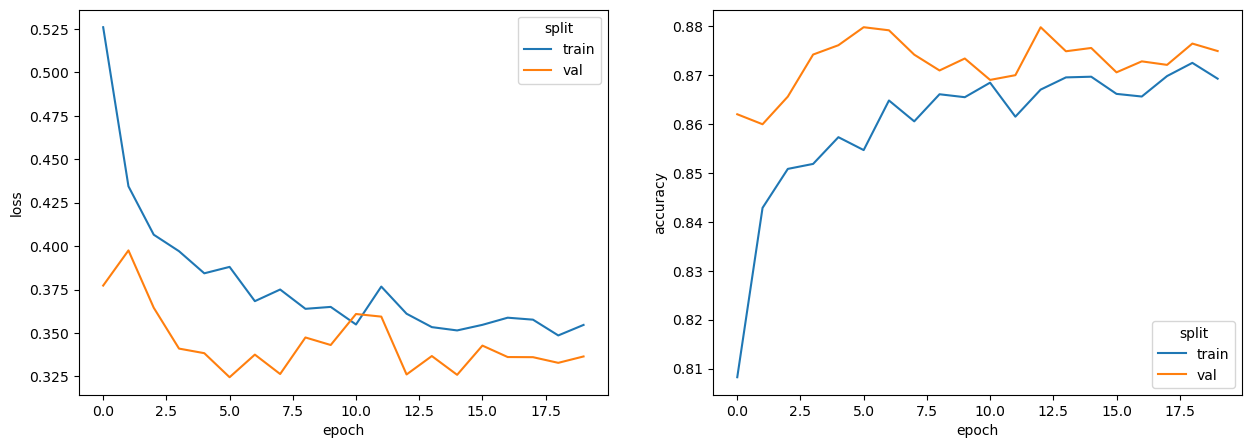

In [48]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[0])

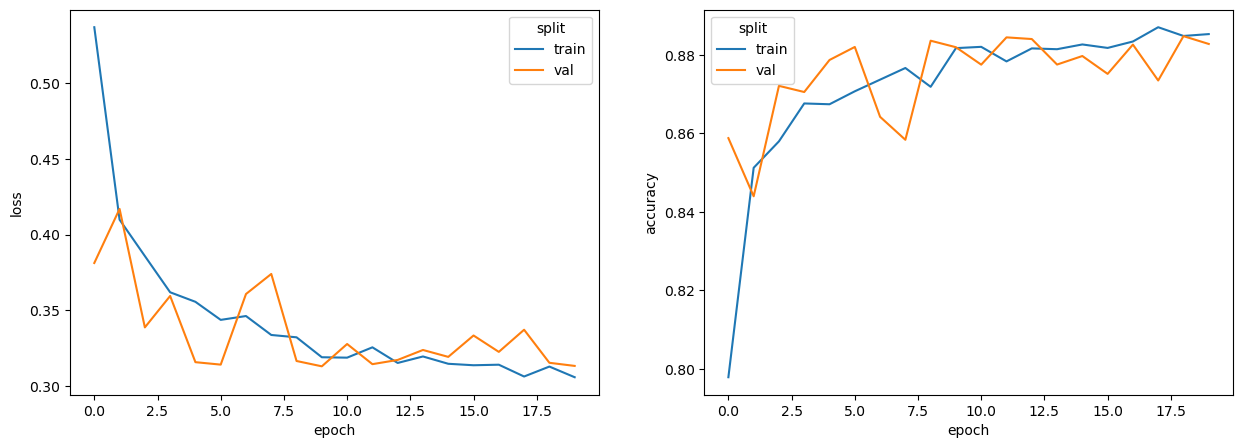

In [49]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[1])

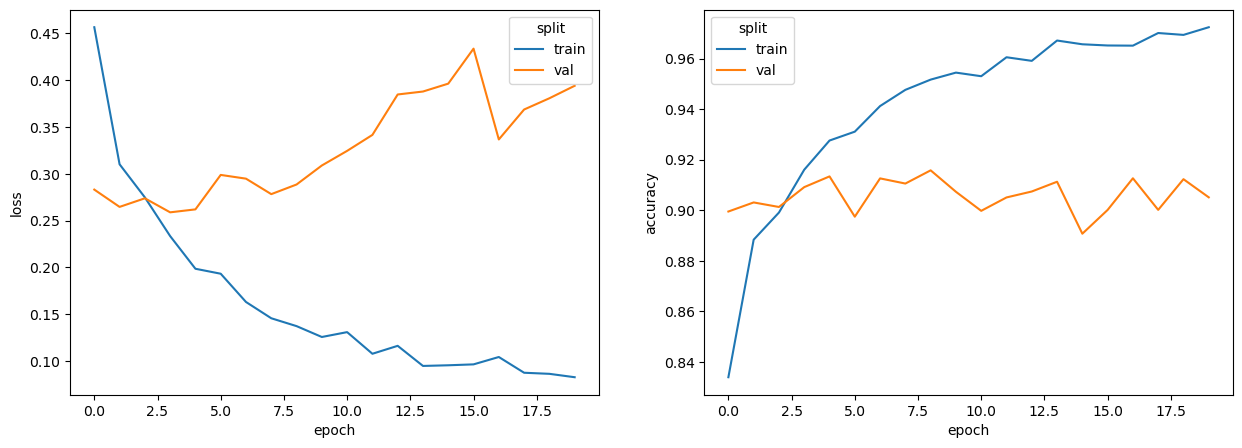

In [50]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[2])

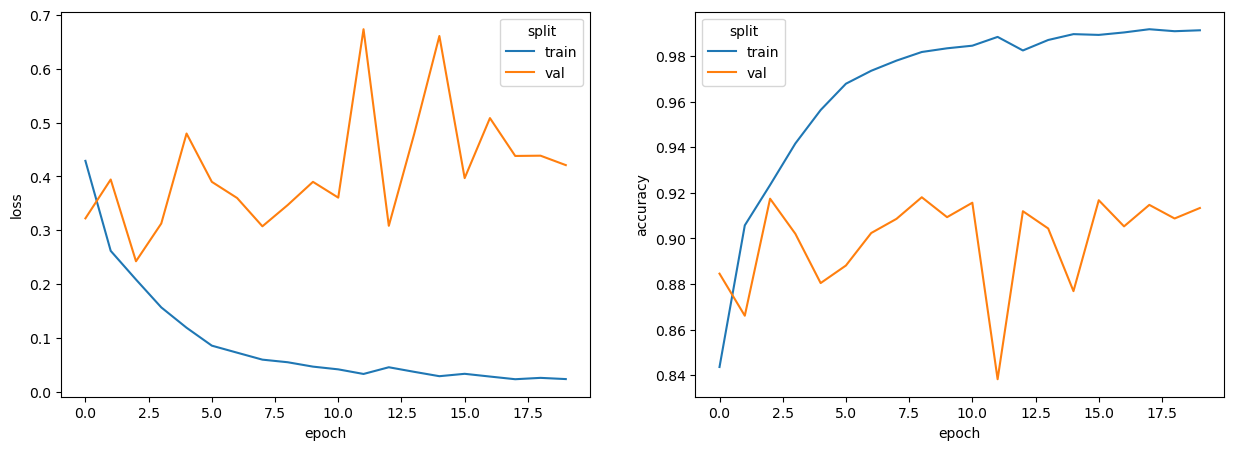

In [51]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[3])

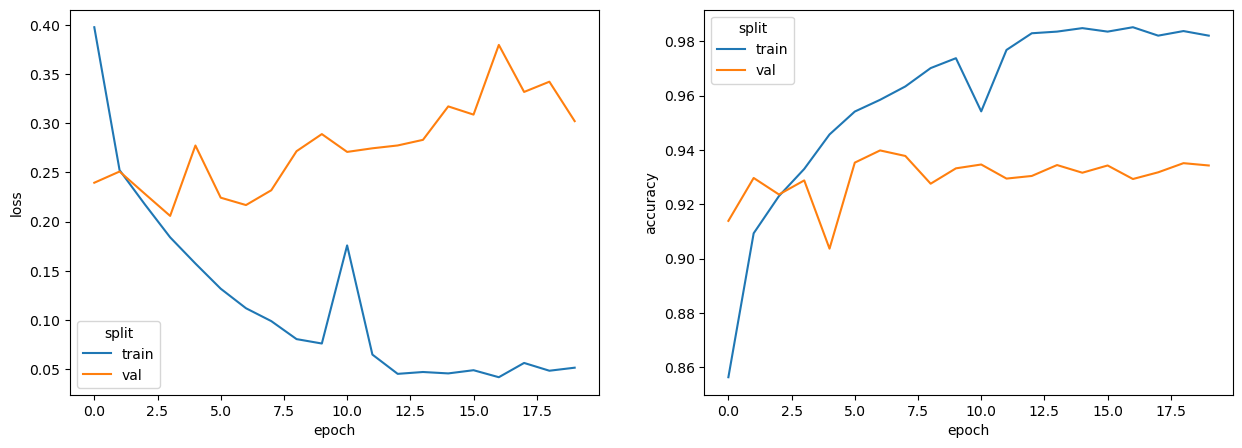

In [52]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[4])

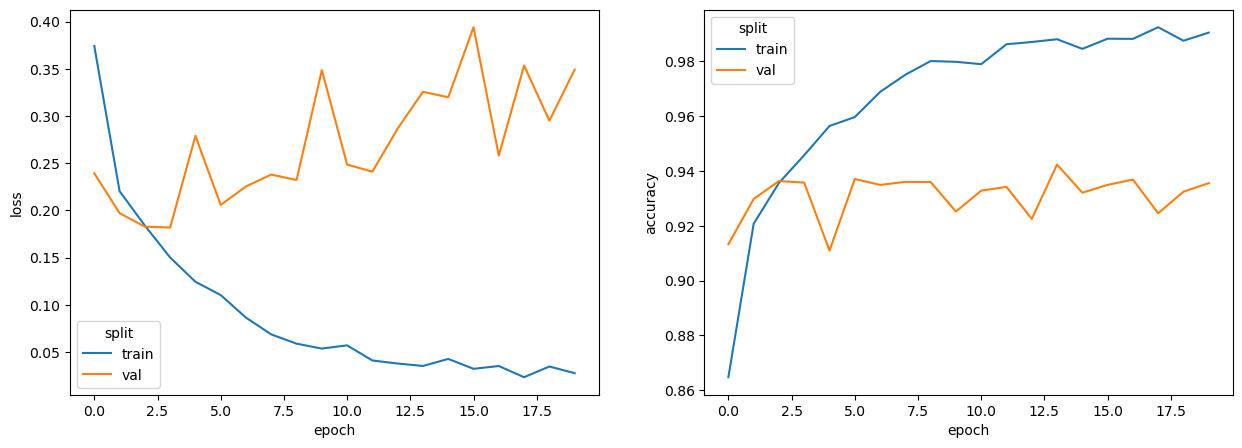

In [53]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[5])

### Evaluation

In [43]:
metrics = {
    "accuracy" : Accuracy(task="multiclass",num_classes=num_classes).to(DEVICE),
    "f1_score" : F1Score(task="multiclass",num_classes=num_classes,average="macro").to(DEVICE),
    "precision" : Precision(task="multiclass",num_classes=num_classes,average="macro").to(DEVICE),
    "recall" : Recall(task="multiclass",num_classes=num_classes,average="macro").to(DEVICE),
    "auc" : AUROC(task="multiclass",num_classes=num_classes,average="macro").to(DEVICE),
}

In [44]:
def compute(models, model_name : str, metrics : dict[str,Metric]):

    Y_hat = []
    Y = []

    test_loader = models[model_name]["test_loader"]
    model = models[model_name]["model"].eval()

    with torch.inference_mode():
        
        for x,y in tqdm(test_loader):

            x, y = x.to(DEVICE), y.to(DEVICE)

            y_hat = model(x)

            Y_hat.append(y_hat)
            Y.append(y)

    Y_hat = torch.cat(Y_hat)
    Y = torch.cat(Y)

    results = {}

    for name,metric in metrics.items():
        results[name] = metric(Y_hat,Y).cpu().numpy()

    return pd.Series(data=results,name=model_name)

In [45]:
def evaluate(models : dict, metrics : dict[str,Metric]) -> pd.DataFrame:

    df = pd.DataFrame()

    for name in models.keys():

        print(f"Evaluating : {name}")

        df[name] = compute(models, name, metrics)

    return df

In [46]:
evaluate(models, metrics)

Evaluating : net=EfficientNet&depth=0


  0%|          | 0/199 [00:00<?, ?it/s]

Evaluating : net=ShuffleNet&depth=0


  0%|          | 0/199 [00:00<?, ?it/s]

Evaluating : net=EfficientNet&depth=1


  0%|          | 0/199 [00:00<?, ?it/s]

Evaluating : net=ShuffleNet&depth=1


  0%|          | 0/199 [00:00<?, ?it/s]

Evaluating : net=EfficientNet&depth=2


  0%|          | 0/199 [00:00<?, ?it/s]

Evaluating : net=ShuffleNet&depth=2


  0%|          | 0/199 [00:00<?, ?it/s]

,net=EfficientNet&depth=0,net=ShuffleNet&depth=0,net=EfficientNet&depth=1,net=ShuffleNet&depth=1,net=EfficientNet&depth=2,net=ShuffleNet&depth=2
accuracy,0.8749606,0.88267714,0.90503937,0.91307086,0.9343307,0.93622047
f1_score,0.8759849,0.88469523,0.9131125,0.9175007,0.9418409,0.9401442
precision,0.8825813,0.88527495,0.92172176,0.9147111,0.942067,0.94749475
recall,0.86994785,0.8849971,0.9053867,0.92306995,0.9416595,0.93617594
auc,0.97497094,0.97794354,0.98300344,0.98616064,0.9896972,0.9902934
